# Import Library

In [67]:
import os
import shutil
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import cv2
from PIL import Image
from sklearn.model_selection import train_test_split



#ignore warning
import warnings
warnings.filterwarnings('ignore')

# Read Direktori

In [68]:
# Direktori dataset
dataset_dir = 'D:/UTY/Semester 7/Pengembangan Aplikasi AI/Pengenal-Citra-Nomor-Kendaraan/Dataset/'

# Membuat path join untuk direktori pelatihan
train_dir = os.path.join(dataset_dir, 'pelatihan')

# Membuat path join untuk direktori pengujian
test_dir = os.path.join(dataset_dir, 'pengujian')

# Split Data

In [69]:
# # Membuat list dari semua nama file citra
# image_files = [f for f in os.listdir(dataset_dir) if f.endswith('.JPG')]

# # Cek apakah ada cukup sampel untuk dilakukan split
# if len(image_files) == 0:
#     raise ValueError("Tidak ada citra yang ditemukan untuk diproses.")

# # Split data hanya jika ada cukup sampel
# if len(image_files) > 1:
#     # Split data menjadi pelatihan dan pengujian
#     train_files, test_files = train_test_split(image_files, test_size=0.2, random_state=42)

#     # Membuat direktori pelatihan dan pengujian jika belum ada
#     os.makedirs(train_dir, exist_ok=True)
#     os.makedirs(test_dir, exist_ok=True)

#     # Memindahkan file ke dalam direktori pelatihan
#     for file in train_files:
#         src_path = os.path.join(dataset_dir, file)
#         dest_path = os.path.join(train_dir, file)
#         shutil.copy(src_path, dest_path)

#     # Memindahkan file ke dalam direktori pengujian
#     for file in test_files:
#         src_path = os.path.join(dataset_dir, file)
#         dest_path = os.path.join(test_dir, file)
#         shutil.copy(src_path, dest_path)
# else:
#     print("Tidak ada cukup citra untuk dilakukan split.")


In [70]:
# Jumlah Data
jumlah_citra_jpg = len([file for file in os.listdir(train_dir) if file.endswith(".JPG")])

print(f"Jumlah citra pelatihan: {jumlah_citra_jpg}")
print(f"Jumlah citra pengujian: {len(os.listdir(test_dir))}")

Jumlah citra pelatihan: 569
Jumlah citra pengujian: 143


# Object Detection

In [71]:
df = pd.read_csv('label.csv')
df.head()

,filepath,xmin,xmax,ymin,ymax
0,./pelatihan\K1_A3772FV.xml,752,1961,1824,2424
1,./pelatihan\K1_A4638EG.xml,813,1887,1615,2067
2,./pelatihan\K1_AA2677GV.xml,774,1813,2459,2863
3,./pelatihan\K1_AA2930VV.xml,709,2031,2389,2867
4,./pelatihan\K1_AA2956JY.xml,874,1809,2189,2650


In [72]:
import xml.etree.ElementTree as xet

filename = df['filepath'][0]
filename

'./pelatihan\\K1_A3772FV.xml'

In [73]:
def getFilename(filename):
    filename_image = xet.parse(filename).getroot().find('filename').text
    filepath_image = os.path.join('./pelatihan',filename_image)
    return filepath_image

In [74]:
getFilename(filename)

'./pelatihan\\K1_A3772FV.JPG'

In [75]:
image_path = list(df['filepath'].apply(getFilename))
image_path[:5]

['./pelatihan\\K1_A3772FV.JPG',
 './pelatihan\\K1_A4638EG.JPG',
 './pelatihan\\K1_AA2677GV.JPG',
 './pelatihan\\K1_AA2930VV.JPG',
 './pelatihan\\K1_AA2956JY.JPG']

# Verify Data

In [76]:
file_path = image_path[0]
file_path

'./pelatihan\\K1_A3772FV.JPG'

In [77]:
img = cv2.imread(file_path)

cv2.namedWindow('example',cv2.WINDOW_NORMAL)
cv2.imshow('example',img)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [78]:
# xmin	xmax	ymin	ymax
# 752	1961	1824	2424
cv2.rectangle(img,(752,1824),(1961,2424),(0,255,0),30)

cv2.namedWindow('example',cv2.WINDOW_NORMAL)
cv2.imshow('example',img)
cv2.waitKey(0)
cv2.destroyAllWindows()

# Data Preprocessing

In [79]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import load_img, img_to_array

In [80]:
# Mengambil Target Xmin, Xmax, Ymin, Ymax
labels = df.iloc[:,1:].values

In [81]:
data =[]
output=[]
for ind in range(len(image_path)):
    image = image_path[ind]
    img_arr = cv2.imread(image)
    h,w,d = img_arr.shape #h,w,d
    # preprocessing
    load_image = load_img(image, interpolation='nearest' ,target_size=(224,224))
    load_image_arr = img_to_array(load_image)
    norm_load_image_arr = load_image_arr/255.0 # normalization
    # normalization to labels
    xmin,xmax,ymin,ymax = labels[ind]
    nxmin,nxmax = xmin/w,xmax/w #/w
    nymin,nymax = ymin/h,ymax/h #/h
    label_norm = (nxmin,nxmax,nymin,nymax) # normalized output
    #---------------append
    data.append(norm_load_image_arr)
    output.append(label_norm)

In [82]:
import numpy as np

# Menimpa list data dengan hasil rotasi
rotated_data = [np.rot90(image_array, k=3) for image_array in data]

# Menetapkan nilai baru ke list data
data = rotated_data

# Split Data

In [83]:
X = np.array(data,dtype=np.float32)
y = np.array(output,dtype=np.float32)

In [84]:
X.shape,y.shape

((569, 224, 224, 3), (569, 4))

In [85]:
x_train,x_test,y_train,y_test = train_test_split(X,y,train_size=0.8, random_state=0)
x_train.shape,x_test.shape,y_train.shape,y_test.shape

((455, 224, 224, 3), (114, 224, 224, 3), (455, 4), (114, 4))

# Deep Learning Model

In [86]:
# Transfer Learning from TensorFlow 2.x
from tensorflow.keras.applications import MobileNetV2, InceptionV3, InceptionResNetV2
from tensorflow.keras.layers import Dense, Dropout, Flatten, Input
from tensorflow.keras.models import Model
import tensorflow as tf

In [87]:
# Model Building InceptionResNetV2
inception_resnet = InceptionResNetV2(weights="imagenet",include_top=False,
                                       input_tensor=Input(shape=(224,224,3)))
inception_resnet.trainable=False
#----------------------
headmodel = inception_resnet.output
headmodel = Flatten()(headmodel)
headmodel = Dense(128,activation='relu')(headmodel) #500
headmodel = Dense(64,activation='relu')(headmodel) #250
headmodel = Dense(1,activation='linear')(headmodel) #4
#--------------------- model
model = Model(inputs=inception_resnet.input,outputs=headmodel)

In [88]:
# Compile model
model.compile(loss='mse',optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4)) #lr=0,0001
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv2d_406 (Conv2D)         (None, 111, 111, 32)         864       ['input_3[0][0]']             
                                                                                                  
 batch_normalization_406 (B  (None, 111, 111, 32)         96        ['conv2d_406[0][0]']          
 atchNormalization)                                                                               
                                                                                                  
 activation_406 (Activation  (None, 111, 111, 32)         0         ['batch_normalization_40

                                                                                                  
 activation_417 (Activation  (None, 25, 25, 64)           0         ['batch_normalization_417[0][0
 )                                                                  ]']                           
                                                                                                  
 mixed_5b (Concatenate)      (None, 25, 25, 320)          0         ['activation_411[0][0]',      
                                                                     'activation_413[0][0]',      
                                                                     'activation_416[0][0]',      
                                                                     'activation_417[0][0]']      
                                                                                                  
 conv2d_421 (Conv2D)         (None, 25, 25, 32)           10240     ['mixed_5b[0][0]']            
          

# Model Training

In [89]:
from tensorflow.keras.callbacks import TensorBoard

In [90]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

In [91]:
tfb = TensorBoard('object_detection')

In [92]:
history = model.fit(x=x_train,y=y_train,batch_size=10,epochs=100,
                    validation_data=(x_test,y_test),callbacks=[tfb, early_stopping])

Epoch 1/100
46/46 [==============================] - 44s 730ms/step - loss: 0.6894 - val_loss: 0.1371
Epoch 2/100
46/46 [==============================] - 30s 666ms/step - loss: 0.1163 - val_loss: 0.0575
Epoch 3/100
46/46 [==============================] - 31s 667ms/step - loss: 0.0534 - val_loss: 0.0480
Epoch 4/100
46/46 [==============================] - 30s 663ms/step - loss: 0.0354 - val_loss: 0.0419
Epoch 5/100
46/46 [==============================] - 30s 664ms/step - loss: 0.0298 - val_loss: 0.0457
Epoch 6/100
46/46 [==============================] - 31s 667ms/step - loss: 0.0287 - val_loss: 0.0409
Epoch 7/100
46/46 [==============================] - 30s 662ms/step - loss: 0.0300 - val_loss: 0.0399
Epoch 8/100
46/46 [==============================] - 30s 663ms/step - loss: 0.0404 - val_loss: 0.0618
Epoch 9/100
46/46 [==============================] - 30s 665ms/step - loss: 0.0493 - val_loss: 0.0476
Epoch 10/100
46/46 [==============================] - 30s 664ms/step - loss: 0.102

In [93]:
history = model.fit(x=x_train,y=y_train,batch_size=10,epochs=312,
                    validation_data=(x_test,y_test),callbacks=[tfb, early_stopping], initial_epoch=100)

Epoch 101/312
46/46 [==============================] - 31s 673ms/step - loss: 0.0672 - val_loss: 0.0492
Epoch 102/312
46/46 [==============================] - 31s 670ms/step - loss: 0.0599 - val_loss: 0.0373
Epoch 103/312
46/46 [==============================] - 31s 669ms/step - loss: 0.0301 - val_loss: 0.0380
Epoch 104/312
46/46 [==============================] - 31s 677ms/step - loss: 0.0270 - val_loss: 0.0354
Epoch 105/312
46/46 [==============================] - 31s 669ms/step - loss: 0.0260 - val_loss: 0.0345
Epoch 106/312
46/46 [==============================] - 31s 670ms/step - loss: 0.0250 - val_loss: 0.0352
Epoch 107/312
46/46 [==============================] - 31s 671ms/step - loss: 0.0246 - val_loss: 0.0344
Epoch 108/312
46/46 [==============================] - 31s 670ms/step - loss: 0.0244 - val_loss: 0.0344
Epoch 109/312
46/46 [==============================] - 31s 669ms/step - loss: 0.0242 - val_loss: 0.0345
Epoch 110/312
46/46 [==============================] - 31s 669ms

In [94]:
# Evaluasi model pada data uji
loss = model.evaluate(x_test, y_test)

# Tampilkan nilai kerugian
print(f'Nilai MSE: {loss:.3f}')

4/4 [==============================] - 5s 1s/step - loss: 0.0344
Nilai MSE: 0.034


In [95]:
# Ambil nilai MSE dari hasil evaluasi model
mse_value = loss

# Hitung RMSE
rmse_value = np.sqrt(mse_value)

# Tampilkan nilai RMSE
print(f'Nilai RMSE: {rmse_value:.3f}')

Nilai RMSE: 0.185


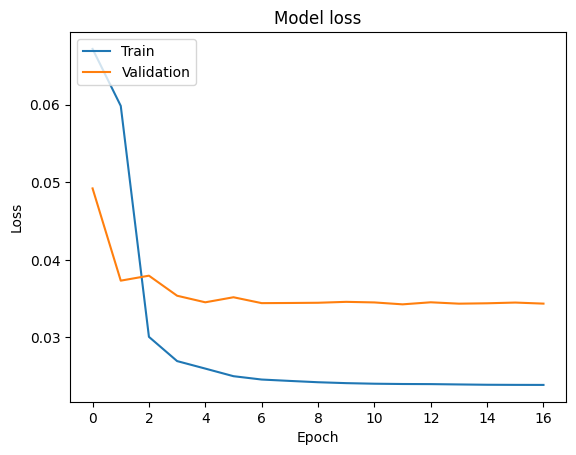

In [96]:
# Memantau history proses training dengan menggunakan library matplotlib.

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [97]:
# Save Model
# model.save('./models/object_detection.h5')

In [98]:
# Tensor Board
# D:\UTY\Semester 7\Pengembangan Aplikasi AI\Pengenal-Citra-Nomor-Kendaraan\Dataset>tensorboard --logdir="object_detection"